Import Packages

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from keras.models import Model
from keras.optimizers import Adam
from keras import Sequential
from keras.models import load_model
from keras.layers import concatenate
from keras.layers import BatchNormalization, Activation, Conv2DTranspose
from keras.layers import Input, Dropout, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

/Users/weihaiyu/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Import Data

In [2]:
img_path = 'Dataset/'
CLASS = 'Yes'
all_files = os.listdir(img_path + CLASS)
files = [item for item in all_files if "img" in item]
random.shuffle(files)
img_num = len(files)
target_size = (240,240)

def load_data():
    train = []  # 定义一个空列表，用于保存数据集
    for (n, file_name) in enumerate(files):
        img = os.path.join(img_path, CLASS, file_name)
        train.append(img)
    return train

In [3]:
x_train = load_data()[:2700]
x_label = load_data()[2700:]

Data Preprocessing (Working On it)

In [4]:
# def horiz_flip(imgs, segs, dice):
#     Fate = random.randint(1, 100)
#     if dice>=Fate:
#         imgs = np.flip(imgs, 1) # 水平翻转
#         segs = np.flip(segs, 1)
#         # res2 = np.flip(img, 0)  # 垂直翻转
#         # res3 = np.flip(img, -1) # 水平垂直翻转
#         return imgs, segs
#     else: return imgs, segs
#
# import skimage
#
# def add_noise(img):
#     Fate = random.randint(1,100)
#     if Fate <= 40:
#         return img
#     elif Fate<=70:
#         "高斯噪声"
#         img = skimage.util.random_noise(img, mode='gaussian', var=0.01)
#         return img
#     else:
#         "椒盐噪声"
#         img = skimage.util.random_noise(img, mode='s&p')
#         return img

Data Generator

In [5]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=32, dim=(240,240), n_channels=3,
                 n_classes=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty(shape=(self.batch_size, *self.dim, self.n_channels))
        y = np.empty(shape=(self.batch_size, *self.dim))
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            # Add data augmentation here
            X[i] = np.load(ID)
            y[i] = np.load(ID.split('_')[0]+'_seg.npy')
        return X,y

Create Data

In [6]:
train_set = DataGenerator(x_train)
val_set = DataGenerator(x_label)
shape = (240,240,3)

Build Unet Model

In [7]:
def build_unet(n_filters=16, dropout=0.1, batchnorm=True, padding='same'):

    # 定义一个多次使用的卷积块
    def conv2d_block(input_tensor, n_filters=16, kernel_size=3, batchnorm=True, padding='same'):
        # the first layer
        x = Conv2D(n_filters, kernel_size, padding=padding)(
            input_tensor)
        if batchnorm:
            x = BatchNormalization()(x)
        x = Activation('relu')(x)

        # the second layer
        x = Conv2D(n_filters, kernel_size, padding=padding)(x)
        if batchnorm:
            x = BatchNormalization()(x)
        X = Activation('relu')(x)
        return X

    # 构建一个输入
    img = Input(shape)

    # contracting path
    c1 = conv2d_block(img, n_filters=n_filters * 1, kernel_size=3, batchnorm=batchnorm, padding=padding)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout * 0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters * 2, kernel_size=3, batchnorm=batchnorm, padding=padding)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters * 4, kernel_size=3, batchnorm=batchnorm, padding=padding)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters * 8, kernel_size=3, batchnorm=batchnorm, padding=padding)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters=n_filters * 16, kernel_size=3, batchnorm=batchnorm, padding=padding)

    # extending path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters * 8, kernel_size=3, batchnorm=batchnorm, padding=padding)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters * 4, kernel_size=3, batchnorm=batchnorm, padding=padding)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters * 2, kernel_size=3, batchnorm=batchnorm, padding=padding)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters * 1, kernel_size=3, batchnorm=batchnorm, padding=padding)

    output = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    return Model(img, output)

Define a metric for the performance of the unet model

In [8]:
def metric_fun(y_true, y_pred):
    fz = tf.reduce_sum(2 * y_true * tf.cast(tf.greater(y_pred, 0.1), tf.float32)) + 1e-5
    fm = tf.reduce_sum(y_true + tf.cast(tf.greater(y_pred, 0.1), tf.float32)) + 1e-5
    # print('------------')
    # print(fz/fm)
    return fz / fm

optimizer = Adam(0.002, 0.5)
model = Sequential()
model.add(build_unet())



model.compile(
    loss='mse',
    optimizer=optimizer,
    metrics=['accuracy',metric_fun]
)

model.summary()

2022-08-06 22:19:36.608218: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-06 22:19:36.608339: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 240, 240, 1)       2164593   
                                                                 
Total params: 2,164,593
Trainable params: 2,161,649
Non-trainable params: 2,944
_________________________________________________________________


Start Training

In [9]:
earlystopping = EarlyStopping(
    monitor='accuracy',
    mode='max',
    patience=20
)

callbacks = [EarlyStopping(patience=100, verbose=2),
                     ReduceLROnPlateau(factor=0.5, patience=20, min_lr=0.00005, verbose=2),
                     ModelCheckpoint('./weights/best_model.h5', verbose=2, save_best_only=True)]

epochs=3


history = model.fit(
    train_set,
    epochs = epochs,
    validation_data = val_set,
    callbacks = callbacks
)

Epoch 1/3


2022-08-06 22:19:37.032592: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-06 22:19:37.741478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


84/84 [==============================] - ETA: 0s - loss: 0.0469 - accuracy: 0.9740 - metric_fun: 0.0544

2022-08-06 22:20:13.380023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.14985, saving model to ./weights/best_model.h5
84/84 [==============================] - 39s 439ms/step - loss: 0.0469 - accuracy: 0.9740 - metric_fun: 0.0544 - val_loss: 0.1499 - val_accuracy: 0.8858 - val_metric_fun: 0.0524 - lr: 0.0020
Epoch 2/3
84/84 [==============================] - ETA: 0s - loss: 0.0125 - accuracy: 0.9920 - metric_fun: 0.3941
Epoch 2: val_loss improved from 0.14985 to 0.02008, saving model to ./weights/best_model.h5
84/84 [==============================] - 37s 434ms/step - loss: 0.0125 - accuracy: 0.9920 - metric_fun: 0.3941 - val_loss: 0.0201 - val_accuracy: 0.9877 - val_metric_fun: 0.0786 - lr: 0.0020
Epoch 3/3
84/84 [==============================] - ETA: 0s - loss: 0.0082 - accuracy: 0.9927 - metric_fun: 0.7376
Epoch 3: val_loss improved from 0.02008 to 0.01680, saving model to ./weights/best_model.h5
84/84 [==============================] - 37s 435ms/step - loss: 0.0082 - accuracy: 0.9927 - metric_fun: 0.7376 - val_

Test Model Here

0
1/1 [==============================] - 0s 226ms/step
1
1/1 [==============================] - 0s 13ms/step


2022-08-06 22:24:24.636046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2
1/1 [==============================] - 0s 15ms/step
3
1/1 [==============================] - 0s 12ms/step
4
1/1 [==============================] - 0s 12ms/step


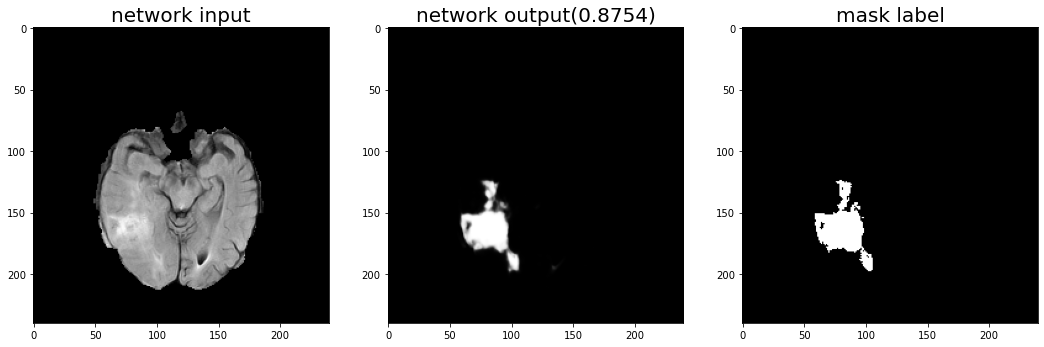

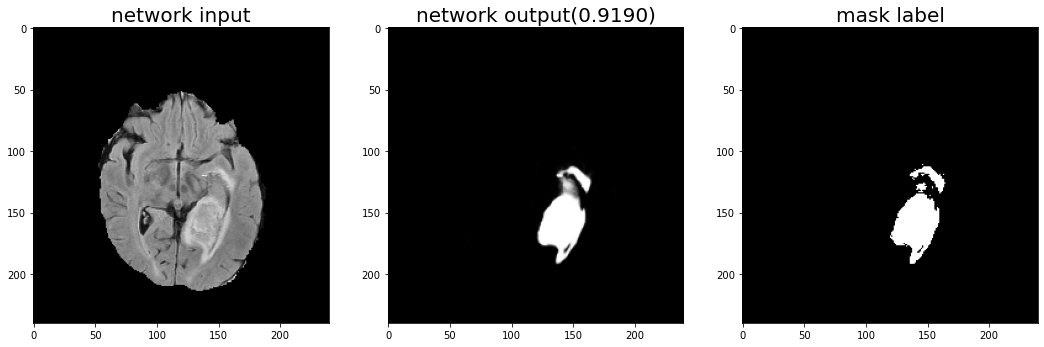

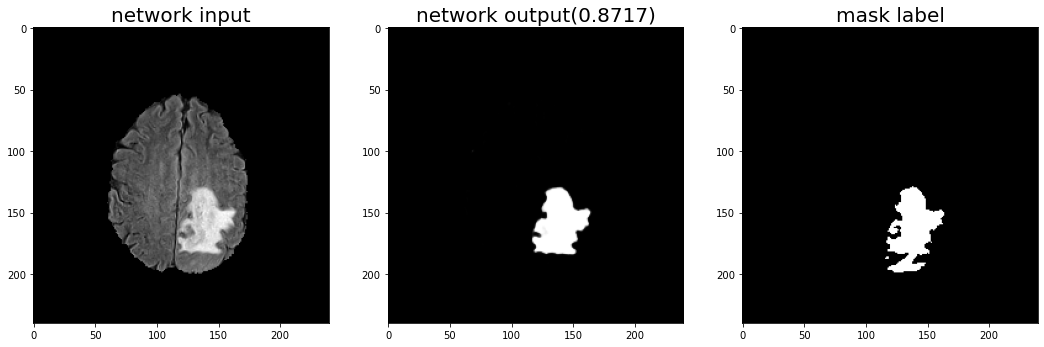

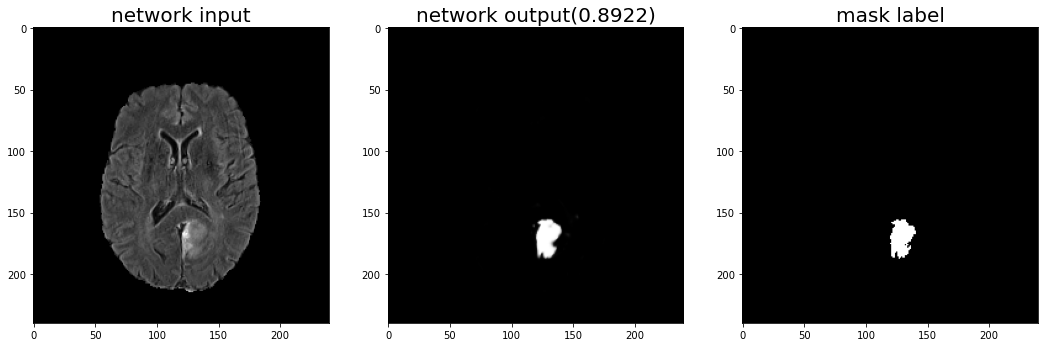

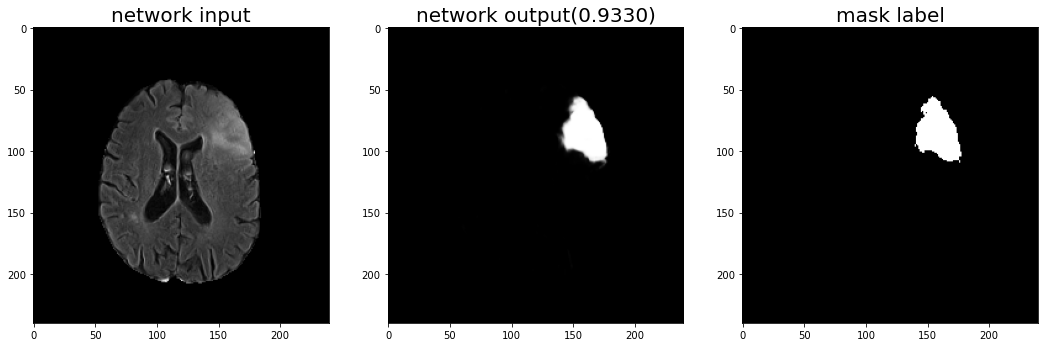

In [15]:
model = load_model('weights/best_model.h5' , compile=False)
test_list = load_data()[:5]
test_generator = DataGenerator(test_list, batch_size=1)

predictions = []
y_test = []

for i in range(test_generator.__len__()):
    print(i)
    x_test, y = test_generator.__getitem__(i)
    y_test.append(y)
    prediction = model.predict(x_test)
    # predictions.append(prediction)
    fig, ax = plt.subplots(1, 3, figsize=(18, 18))
    ax[0].imshow(x_test[0,:,:,0], cmap='gray')
    ax[0].set_title('network input', fontsize=20)
    # calculate dice
    fz = 2 * np.sum(prediction.squeeze() * y.squeeze())
    fm = np.sum(prediction.squeeze()) + np.sum(y.squeeze())
    dice = fz / fm
    ax[1].imshow(prediction.squeeze()[:,:], cmap='gray')
    ax[1].set_title('network output(%.4f)' % dice, fontsize=20)  # 设置title
    ax[2].imshow(y.squeeze()[:,:], cmap='gray')
    ax[2].set_title('mask label', fontsize=20)

# test_num = y_train.shape[0]
# for epoch in range(5):
#     rand_index = []
#     while len(rand_index) < 3:
#         np.random.seed()
#         temp = np.random.randint(0, test_num, 1)
#         if np.sum(x_label[temp]) > 0:  # 确保产生有肿瘤的编号
#             rand_index.append(temp)
#     rand_index = np.array(rand_index).squeeze()
#     fig, ax = plt.subplots(3, 3, figsize=(18, 18))
#     for i, index in enumerate(rand_index):
#         mask = model.predict(x_train[index:index + 1]) > 0.1
#         ax[i][0].imshow(x_train[index].squeeze()[:,:,0], cmap='turbo')
#         ax[i][0].set_title('network input', fontsize=20)
#         # 计算dice系数
#         fz = 2 * np.sum(mask.squeeze() * x_label[index].squeeze())
#         fm = np.sum(mask.squeeze()) + np.sum(x_label[index].squeeze())
#         dice = fz / fm
#         ax[i][1].imshow(mask.squeeze()[:,:])
#         ax[i][1].set_title('network output(%.4f)' % dice, fontsize=20)  # 设置title
#         ax[i][2].imshow(x_label[index].squeeze()[:,:])
#         ax[i][2].set_title('mask label', fontsize=20)
#     fig.savefig('./evaluation/show%d_%d_%d.png' % (rand_index[0], rand_index[1], rand_index[2]),
#                 bbox_inches='tight', pad_inches=0.1)  # 保存绘制的图片
#     print('finished epoch: %d' % epoch)
#     plt.close()